<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# NIRSpec MOS Pipeline Notebook

**Authors**: Dan Coe (dcoe@stsci.edu), Kayli Glidic (kglidic@stsci.edu), NIRSpec branch, with contributions from the NIRSpec team, including Elena Manjavacas, Peter Zeidler, Melanie Clarke, James Muzerolle, Nikolay Nikolov, Chris Hayes, and Alaina Henry, who designed the ERO NIRSpec observations.<br>
**Last Updated**: April 16, 2025 </br>
**Pipeline Version**: 1.80.1 (Build 11.3, Context jwst_1364.pmap)

**Purpose**:<br>
End-to-end calibration with the James Webb Space Telescope (JWST) pipeline is divided into three main processing stages. This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) multi-object spectroscopy (MOS) data through [stages 1-3 of the JWST pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing#gsc.tab=0), including how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options or plot parameters need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**:<br>
This notebook is set up to use observations of galaxy cluster SMACS0723 with the G395M grism obtained by Proposal ID (PID) 2736, Observation 7. The demo data will automatically download unless disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-mos-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra&gsc.tab=0:~:text=MOS%20Known%20Issues-,NIRSpec%20MOS%20Known%20Issues,-Known%20issues%20specific) for this build are noted in the notebook. 

**Updates**:<br>
This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/).

**Recent Changes**:</br>
* October 15, 2024: Converted notebook to follow standard template ([original](https://github.com/dancoe/NIRSpec/blob/main/NIRSpec%20MOS%20pipeline.ipynb)). </br>
* November 4, 2024: Notebook updated to JWST pipeline version 1.16.0 (Build 11.1).
* January 12, 2024: Added an example for association file creation.
* February 19, 2025: Updated JWST pipeline version 1.17.1 (Build 11.2). Changed code to create all associations instead of using the MAST downloads.
* April 16, 2025: Updated JWST pipeline version 1.80.0 (Build 11.3) and added Jdaviz plotting options.

---

## Table of Contents

* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#5.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` Association Files](#6.2-Create-Spec2Pipeline-Association-Files)
    * [6.3 MSA Metadata File](#6.3-MSA-Metadata-File)
    * [6.4 Run `Spec2Pipeline`](#6.4-Run-Spec2Pipeline)
* [7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)](#5.-Stage-3:-Spec3Pipeline-(calwebb_spec3))
    * [7.1 Configure `Spec3Pipeline`](#7.1-Configure-Spec3Pipeline)
    * [7.2 Create `Spec3Pipeline` Association Files](#7.2-Create-Spec3Pipeline-Association-Files)
    * [7.3 Run `Spec3Pipeline`](#7.3-Run-Spec3Pipeline)
* [8. Visualize the Data](#8.-Visualize-the-Data)
    * [8.1 Display `Detector1Pipeline` Products](#8.1-Display-Detector1Pipeline-Products)
    * [8.2 Display `Spec2Pipeline` Products](#8.2-Display-Spec2Pipeline-Products)
    * [8.3 Display `Spec3Pipeline` Products](#8.3-Display-Spec3Pipeline-Products)
* [9. Modifying the EXTRACT1D Reference File (as needed)](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))
---

## 1. Configuration

#### Install dependencies and parameters
To make sure that the pipeline version is compatible with the steps discussed below and that the required dependencies and packages get installed, you can create a fresh conda environment and install the provided requirements.txt file before starting this notebook:

    conda create -n nirspec_mos_pipeline python=3.12
    conda activate nirspec_mos_pipeline
    pip install -r requirements.txt

#### Set the basic parameters to configure the notebook

These parameters determine what data gets used, where data is located (if already on disk), and the type of background subtraction (if any). The list of parameters includes:
* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location.<br><br>
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.

* **[Backgroud subtraction methods](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-strategies/nirspec-background-recommended-strategies#gsc.tab=0)** (`True` = run, `False` = skip):
    * `master_bg`: Apply master-background subtraction in `calwebb_spec2`? Uses "blank sky" shutters defined in the observation.
    * `pixel_bg` : Apply pixel-to-pixel background subtraction in `calwebb_spec2`.  This is the default pipeline setting. Uses nodded observations.<br><br>

In [1]:
# Basic import necessary for configuration.
# Uncomment logging to hide log information.

import os
import warnings
#import logging

# Control logging level: INFO, WARNING, ERROR
# Run command loging.disable if want to hide logging
# ERROR messages.
#logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">

Note that `demo_mode` must be set appropriately below.

</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -------------------------------DEMO MODE-----------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories----------------------------
else:  # If demo_mode = False, look for user data in these paths.

    # Set directory paths for processing specific data; adjust to your local
    # directory setup (examples provided below).
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))

    # Directory to science observation data; expects uncalibrated data in
    # sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    sci_dir = os.path.join(basedir, 'mos_data_02736/Obs007', '')

# --------------------------Set Processing Steps-----------------------------
# Individual pipeline stages can be turned on/off here. Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing.
dodet1 = True  # calwebb_detector1
dospec2 = True  # calwebb_spec2
dospec3 = True  # calwebb_spec3
doviz = True  # Visualize calwebb outputs

# ---------------------------Set Processing Steps----------------------------
# How should background subtraction be done?
# If none are selected, data will not be background subtracted.
# pixel_bg - True for nodded observations.
# master_bg - True if using "blank sky" sutters in the science observation.
master_bg = False  # Master-background subtraction in spec2.
pixel_bg = True  # Pixel-based background subtraction in spec2.

Running in demonstration mode using online example data!


---
### Set CRDS Context and Server
Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.<br><br>
[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths------------------------

# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1364.pmap'  # CRDS context for 1.18.0

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /Users/kglidic/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


---
## 2. Package Imports

In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML, JSON
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# ----------------------General Imports----------------------
import time
import glob
import json
import itertools
import numpy as np
from itertools import combinations

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# -------------------- Astroquery Imports ----------------------
from astroquery.mast import Observations

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from jdaviz import Mosviz

<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) •
[Github](https://github.com/spacetelescope/jwst)

</div>

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
import jwst  # Import the base JWST and CRDS packages.
import crds
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Spec3Pipeline  # calwebb_spec3
from jwst.extract_1d import Extract1dStep  # Extract1D Step

# JWST pipeline utilities
from jwst import datamodels  # JWST pipeline utilities: datamodels.
from jwst.associations import asn_from_list as afl  # Tools for creating association files.
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Define Lvl2 ASN.
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Define Lvl3 ASN.

default_context = crds.get_default_context('jwst', state='build')
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print(f"Default CRDS Context for JWST Version {jwst.__version__}: {default_context}")
print(f"Using CRDS Context: {os.environ.get('CRDS_CONTEXT', default_context)}")

CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/jwst-1.18.0.dist-info)


JWST Calibration Pipeline Version = 1.18.0
Default CRDS Context for JWST Version 1.18.0: jwst_1364.pmap
Using CRDS Context: jwst_1364.pmap


---
### Define Convience Functions

Define a function that identifies unique MSA files.

In [7]:
# Find unique files to download.
def unique_files_to_array(files):
    """
    Checks for unique files and adds them to an array.

    Parameters
    ----------
    files : list of lists
        The input files.

    Returns
    -------
    list : An array of unique files.
    """

    unique_files = set()
    for row in files:
        for element in row:
            if isinstance(element, str):
                unique_files.add(element)

    return list(unique_files)

Define a function that filters files based on detector, filter, and grating.

In [8]:
def get_matching(files, detector, filt, grating, exp_type):
    """
    Filters a list of FITS files to find those with matching 
    detector, filter, and grating for a specified exposure type.

    Parameters
    ----------
    files : list of str
        Paths to FITS files to check.
    detector : str
        Expected value of the DETECTOR keyword.
    filt : str
        Expected value of the FILTER keyword.
    grating : str
        Expected value of the GRATING keyword.
    exp_type : str, optional
        The exposure type to match.

    Returns
    -------
    files_regular : list of str
        Files with matching configuration and IS_IMPRT == False or missing.
    files_imprint : list of str)
        Files with matching configuration and IS_IMPRT == True.
    """
    files_regular, files_imprint = [], []
    for file in files:
        # Skip if EXP_TYPE doesn't match the provided one.
        if fits.getval(file, 'EXP_TYPE') != exp_type:
            files_regular.append(file)
            continue
        # Check if DETECTOR, FILTER, and GRATING match
        if (fits.getval(file, 'DETECTOR') == detector and
            fits.getval(file, 'FILTER') == filt and
            fits.getval(file, 'GRATING') == grating):
            # Only IFU and MOS observations have imprint exposures.
            try:
                is_imprt = fits.getval(file, 'IS_IMPRT')
            except KeyError:
                is_imprt = None
            (files_imprint if is_imprt else files_regular).append(file)
    return files_regular, files_imprint

In [9]:
# Start a timer to keep track of runtime.
time0 = time.perf_counter()

---
## 3. Demo Mode Setup (ignore if not using demo data)
<div class="alert alert-block alert-info">

The data in this notebook is public and does not require a token. For other data sets, you may need to provide a token. For more infomation visit the
[astroquery](https://astroquery.readthedocs.io/en/latest/index.html) documentation.

</div>

If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).

The MOS demo data in this notebook is from ["JWST's First Deep Field"](https://webbtelescope.org/contents/news-releases/2022/news-2022-035), [JWST Early Release Observation (ERO) program 2736](https://www.stsci.edu/jwst/science-execution/program-information?id=2736) and features observations of galaxy cluster SMACS0723 with NIRCam, NIRSpec, and MIRI. This program includes two identical MOS observations (7 and 8) with confirmation images taken after target acquisition (20 groups | NRSIRS2RAPID | 306 [s]). More of the program setup is briefly summarized in the table below.

| Demo Target: SMACS0723 |       |   |
|:-----------:|:-------:|:---:|
| PROGRAM | 02736 | Program number |
| OBSERVTN | 007 | Observation number |
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-multi-object-spectroscopy#gsc.tab=0:~:text=Table%C2%A01.%20Spectral%20configurations%20available%20in%20NIRSpec%20MOS%20mode) | G395M/F290LP | λ: 2.87–5.10 μm (a medium resolution, R ~ 1000) |
||G235M/F170LP | λ: 1.66–3.07 μm (a medium resolution, R ~ 1000) |
| SUBARRAY | FULL | Subarray used (2048 x 2048) |
| NINTS | 2 | Number of integrations in exposure |
| NGROUPS | 20 | Number of groups in integration |
| READPATT | NRSIRS2 | Readout pattern |
| NOD_TYPE | 3-SHUTTER-SLITLET | Nod pattern type |
| NUMDTHPT | 3 |  Total number of points in pattern |      
| SRCTYAPT | UNKNOWN | Source type selected in APT |
| TOTAL DURATION | NOD_TYPE x NINTS x NGROUPS = 8841 [s] (~2.5 hrs) | Total duration (per grating and observation)|

> **Note:** The presence of a physical gap between detectors affects all MOS observations (any resolution) because the spectra can be long enough to span both NIRSpec detectors. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-mos-operations/nirspec-mos-wavelength-ranges-and-gaps#gsc.tab=0)

In [10]:
# Set up the program information and directories to collect
# the data in demo_mode.

if demo_mode:

    print('Running in demonstration mode. '
          'Example data will be downloaded from MAST!')

    # NOTE:
    # For non public data sets, you may need to provide a token.
    # However, for security it is not recommended to enter tokens into
    # a terminal or Jupyter notebook.
    #Observations.login(token="your-token")

    # --------------Program and observation information--------------
    program = "02736"
    sci_observtn = "007"
    filters = ["F290LP;G395M"]

    # ----------Define the base and observation directories----------
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))
    sci_dir = os.path.join(basedir, f'mos_data_{program}')
    sci_dir = os.path.join(sci_dir, f'Obs{sci_observtn}')
    uncal_dir = os.path.join(sci_dir, 'uncal/')
    asn_dir = os.path.join(sci_dir, 'asn/') # Keep MSA files in the association directory.

    # ----Ensure directories for downloading MAST data exists--------
    os.makedirs(uncal_dir, exist_ok=True)
    os.makedirs(asn_dir, exist_ok=True)

Running in demonstration mode. Example data will be downloaded from MAST!


<br>Click on the following links to learn more about querying and downloading data:<br>
• [Downloading data](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data)<br>
• [Observations Class](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html)<br>
• [Products Field Descriptions](https://mast.stsci.edu/api/v0/_productsfields.html)<br><br>

Compile a table of files from MAST associated with the science (SCI) observation.

In [11]:
# Obtain a list of observation IDs for the specified demo program.

if demo_mode:
    # --------------------SCIENCE Observation--------------------
    sci_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/MSA'],
                                                   provenance_name=["CALJWST"],
                                                   obs_id=[f'*{program}*{sci_observtn}*'])

Filter these tables to identify uncalibrated and metadata files to download from MAST.

The demo dataset consists of six `_uncal.fits` files, each approximately 500 MB in size.

In [12]:
# Convert visits into a list of uncalibrated data and ASN files.

if demo_mode:

    file_criteria = {'filters': filters, 'calib_level': [1],
                     'productSubGroupDescription': 'UNCAL'}

    # Initialize lists for science and metadata files.
    sci_downloads, msa_downloads = [], []

    pfilter = Observations.filter_products  # Alias for filter_products method.

    # ----Identify uncalibrated SCIENCE files associated with each visit-----
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)

        # Filter for full-size science files (exclude smaller confirmation images).
        avg_sci_size = np.nanmean(sci_products['size'])
        sci_products_avg = sci_products[sci_products['size'] > avg_sci_size]
        sci_downloads.extend(pfilter(sci_products_avg, **file_criteria)['dataURI'])

        # Identifies association metadata files.
        msa_files = {
            f['productFilename'] for f in sci_products
            if 'AUXILIARY' in f['productType'] and 'metadata' in f['description']}
        msa_downloads.append(msa_files)

    # Filter out other observations and remove duplicates.
    msa_downloads = unique_files_to_array(msa_downloads)
    sci_downloads = {f for f in sci_downloads if f"jw{program}{sci_observtn}" in f}

    msa_mast_downloads = [
        f"mast:JWST/product/{f}" for f in msa_downloads
        if f"jw{program}{sci_observtn}" in f
    ]

    print(f"Science files selected for downloading: {len(sci_downloads)}")
    print(f"MSA files selected for downloading: {len(msa_mast_downloads)}")

Science files selected for downloading: 6
MSA files selected for downloading: 1


Download the data.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

In [13]:
# Download data and place them into the appropriate directories.

if demo_mode:
    for file in sci_downloads:
        sci_manifest = Observations.download_file(file, local_path=uncal_dir)
    for file in msa_mast_downloads:
        msa_manifest = Observations.download_file(file, local_path=asn_dir)

2025-04-18 01:13:51,897 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs2_uncal.fits with expected size 524341440.
2025-04-18 01:13:52,028 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs1_uncal.fits with expected size 524341440.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs2_uncal.fits with expected size 524341440. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs1_uncal.fits with expected size 524341440. [astroquery.query]


2025-04-18 01:13:52,137 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs2_uncal.fits with expected size 524341440.
2025-04-18 01:13:52,253 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs1_uncal.fits with expected size 524341440.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs2_uncal.fits with expected size 524341440. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs1_uncal.fits with expected size 524341440. [astroquery.query]


2025-04-18 01:13:52,389 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs2_uncal.fits with expected size 524341440.
2025-04-18 01:13:52,507 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs1_uncal.fits with expected size 524341440.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs2_uncal.fits with expected size 524341440. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs1_uncal.fits with expected size 524341440. [astroquery.query]


2025-04-18 01:13:52,624 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736007001_01_msa.fits with expected size 578880.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736007001_01_msa.fits with expected size 578880. [astroquery.query]


---
### Galaxies of Interest
There are several galaxies of interest in the demo data. Here we will look at some of them (source_ids provided below).

* **6355**: z = 7.665 (13.0 Gyr ago)
    * We'll look at this galaxy in this notebook.
    * Excellent spectrum with bright lines.
    * 5-shutter slitlet (rather than standard 3-shutter slitlet), so 1D extraction can be improved significantly.
    * Not a multiple image of 10612 (described below), which has a similar redshift.

* 5144: z = 6.383 (12.8 Gyr ago)

The following galaxies have been featured in the [press release](https://webbtelescope.org/contents/news-releases/2022/news-2022-035):
*  4590: z = 8.498 (13.1 Gyr ago)
* 10612: z = 7.663 (13.0 Gyr ago)
*  8140: z = 5.275 (12.6 Gyr ago)
*  9922: z = 2.743 (11.3 Gyr ago)

and presented and studied in papers including
[Katz et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518..592K),
[Curti et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518..425C),
[Carnall et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518L..45C).

---
## 4. Directory Setup
Set up detailed paths to input/output stages here.

In [14]:
# Define/create output subdirectories to keep data products organized.

# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
spec3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_spec3 pipeline outputs.
asn_dir = os.path.join(sci_dir, 'asn/')  # Associations directory.

# Creates the directories if target directory does not exist.
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(spec3_dir, exist_ok=True)
os.makedirs(asn_dir, exist_ok=True)

In [15]:
# Print out the time benchmark.
time1 = time.perf_counter()
print(f"Runtime so far: {round((time1 - time0) / 60.0, 1):0.4f} min")

Runtime so far: 1.4000 min


---
## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)
In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing.

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec MOS:

* `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
* `dq_init` : Initializes the data quality (DQ) flags for the input data.
* `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
* `superbias` : Subtracts the superbias reference file from the input data.
* `refpix` : Use reference pixels to correct bias drifts.
* `linearity` : Applies a correction for non-linear detector response.
* `dark_current` : Subtracts the dark current reference file from the input data.
* `jump` : Performs CR/jump detection on each ramp integration within an exposure.
* `clean_flicker_noise`: Removes flicker (1/f) noise from calibrated ramp images (similar to `nsclean` in spec2).
* `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
* `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for MOS data. We follow the [CEERS NIRSpec reduction parameters](https://web.corral.tacc.utexas.edu/ceersdata/DR07/NIRSpec/README_NIRSpec_DR0.7.txt) to improve the rejection of cosmic rays and snowballs during the `jump` step.

<div class="alert alert-warning">
To override specific steps and reference files, use the examples below.
</div>

In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'] = {}, {}
det1dict['linearity'], det1dict['dark_current'], det1dict['jump'] = {}, {}, {}
det1dict['clean_flicker_noise'], det1dict['ramp_fit'] = {}, {}
det1dict['gain_scale'] = {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#det1dict['dq_init']['override_mask'] = 'myfile.fits'  # Bad pixel mask
#det1dict['superbias']['override_superbias'] = 'myfile.fits'  # Bias subtraction
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
det1dict['linearity']['skip'] = False  # This is the default.

# Turn on multi-core processing (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'half'
#det1dict['ramp_fit']['maximum_cores'] = 'half'

In [17]:
# Turn on detection of cosmic ray snowballs (on by default)
# and change some parameters.
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['expand_factor'] = 3  # (default 2)
det1dict['jump']['min_sat_area'] = 15  # (default 1)
det1dict['jump']['min_jump_area'] = 15  # (default 5)

<div class="alert alert-info">

Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.

</div>

In [18]:
# Turn on 1/f noise correction in Stage 1? (off by default).
#det1dict['clean_flicker_noise']['skip'] = False

<div class="alert alert-info">

JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This noise manifests as faint banding along the detector's slow axis and varies from column to column. For NIRSpec data, the primary pipeline algorithm to address 1/f noise is `nsclean` in the `Spec2Pipeline` (Rauscher 2023) but is off by default.

An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default.

</div>

---
### 5.2 Run `Detector1Pipeline`
Run the science files through the `calwebb_detector1` pipeline using the `.call()` method.

We use `.call()` instead of `.run()` to ensure that the latest default parameters set via reference files in CRDS are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).

This stage takes approximately 25 minutes to process six `_uncal.fits` files (~4 minutes per file) and generate `_rate.fits` files.

In [19]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))
print(f"Science UNCAL Files:\n{'-' * 20}\n" + "\n".join(uncal_sci))

Science UNCAL Files:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs1_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs2_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs1_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs2_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs1_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs2_uncal.fits


In [20]:
time_det1 = time.perf_counter()  # Tracks runtime for Stage 1.

In [21]:
# Run Stage 1 pipeline using the custom det1dict dictionary.

if dodet1:
    # --------------------------Science UNCAL files--------------------------
    for uncal_file in uncal_sci:
        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1_result = Detector1Pipeline.call(uncal_file,
                                             save_results=True,
                                             steps=det1dict,
                                             output_dir=det1_dir)
    print("Stage 1 has been completed! \n")
else:
    print('Skipping Detector1 processing for SCI data.')

Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00001_nrs1_uncal.fits


2025-04-18 01:13:53,601 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/jwst-1.18.0.dist-info)
2025-04-18 01:13:53,866 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf
2025-04-18 01:13:53,874 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf
2025-04-18 01:13:53,883 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2025-04-18 01:13:53,903 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-04-18 01:13:53,904 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-04-18 01:13:53,905 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-04-18 01:13:53,906 - s

Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00001_nrs2_uncal.fits


2025-04-18 01:15:23,946 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf
2025-04-18 01:15:23,953 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf
2025-04-18 01:15:23,960 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2025-04-18 01:15:23,983 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-04-18 01:15:23,983 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-04-18 01:15:23,984 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-04-18 01:15:23,985 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2025-04-18 01:15:23,985 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep ins

Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00002_nrs1_uncal.fits


2025-04-18 01:16:56,518 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf
2025-04-18 01:16:56,525 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf
2025-04-18 01:16:56,533 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2025-04-18 01:16:56,552 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-04-18 01:16:56,552 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-04-18 01:16:56,553 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-04-18 01:16:56,554 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2025-04-18 01:16:56,554 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep ins

Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00002_nrs2_uncal.fits


2025-04-18 01:18:31,657 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf
2025-04-18 01:18:31,682 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf
2025-04-18 01:18:31,701 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2025-04-18 01:18:31,728 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-04-18 01:18:31,744 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-04-18 01:18:31,747 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-04-18 01:18:31,758 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2025-04-18 01:18:31,763 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep ins

Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00003_nrs1_uncal.fits


2025-04-18 01:20:08,010 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf
2025-04-18 01:20:08,016 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf
2025-04-18 01:20:08,023 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2025-04-18 01:20:08,041 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-04-18 01:20:08,042 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-04-18 01:20:08,042 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-04-18 01:20:08,043 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2025-04-18 01:20:08,044 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep ins

Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00003_nrs2_uncal.fits


2025-04-18 01:21:46,792 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0003.asdf
2025-04-18 01:21:46,799 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf
2025-04-18 01:21:46,807 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2025-04-18 01:21:46,826 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-04-18 01:21:46,826 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-04-18 01:21:46,827 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-04-18 01:21:46,828 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2025-04-18 01:21:46,829 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep ins

Stage 1 has been completed! 



In [22]:
# Print output result details:
#det1_result.__dict__  # View entire contents.
#det1_result.meta.filename
#det1_result.data.shape

In [23]:
# Print out the time benchmark.
time2 = time.perf_counter()
print(f"Runtime so far: {round((time2 - time0) / 60.0, 1):0.4f} min")
print(f"Runtime for Stage 1: {round((time2 - time_det1) / 60.0, 1):0.4f} min")

Runtime so far: 10.9000 min
Runtime for Stage 1: 9.5000 min


In [24]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir + '*_rate.fits'))
rateints_sci = sorted(glob.glob(det1_dir + '*_rateints.fits'))
print(f"SCIENCE | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_sci + rateints_sci))


SCIENCE | RATE[INTS] Files:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-not

---
## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)
In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
>* `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
>* `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows).
>* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).

In Stage 2, each exposure (or association) and detector produces a single file, with multiple extensions corresponding to each source.

The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per nod/dither position). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

---

### 6.1 Configure `Spec2Pipeline`
The `Spec2Pipeline` has the following steps available for NIRSpec MOS:

* `assign_wcs`: Associates a WCS object with each exposure.
* `badpix_selfcal`: Flags bad pixels in the input data using a self-calibration technique based on median filtering along the spectral axis.
* `msaflagopen`: Flags pixels in NIRSpec exposures affected by MSA shutters stuck in the open position.
* `nsclean`: Cleans 1/f noise.
* `imprint`: Removes patterns caused by the MSA structure in NIRSpec MOS and IFU exposures.
* `bkg_subtract`: Performs image subtraction for background removal.
* `extract_2d` : Extracts 2D arrays from spectral images.
* `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
* `master_background` : Subtracts background signal from 2D spectroscopic data using a 1D master background spectrum.
* `wavecorr` : Updates wavelength assignments for FS and MOS point sources that are offset in the dispersion direction within their slit.
* `flat_field`: Applies flat-field corrections to the input science dataset.
* `pathloss`: Calculates and applies corrections for signal loss in spectroscopic data.
* `barshadow` : Calculates the correction to NIRSpec MOS data for extended sources affected by the bar that separates adjacent microshutters.
* `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
* `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
* `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
* `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for MOS data.

<div class="alert alert-warning">
If pixel-to-pixel or master background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below.
</div>

In [25]:
# Select source to inspect.
# Set None to proccess all sources.
source_ids, slit_names = None, None

if demo_mode:
    # The pipeline will accept a list of source IDs or slit names.
    # Galaxies of interest:
    source_ids = [
        6355,
        # 5144, 4590, 10612, 8140, 9922
        ]
    
    slit_names = [
        '72',
        # '51', '55', '69', '16', '64'
        ]

# If running master background subtraction,
# make sure we don't restrict to one slit.
elif not master_bg:
    source_ids, slit_names = None, None

In [26]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal'] = {}, {}
spec2dict['nsclean'], spec2dict['master_background_mos'] = {}, {}
spec2dict['barshadow'], spec2dict['extract_2d'] = {}, {}
spec2dict['bkg_subtract'], spec2dict['srctype'], spec2dict['wavecorr'] = {}, {}, {}
spec2dict['flat_field'], spec2dict['pathloss'] = {}, {}
spec2dict['photom'], spec2dict['pixel_replace'] = {}, {}
spec2dict['resample_spec'], spec2dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec2dict['bkg_subtract']['skip'] = not pixel_bg  # Runs if pixel-to-pixel bkg selected.
spec2dict['master_background_mos']['skip'] = not master_bg  # Runs if masterbg selected.

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec2dict['pixel_replace']['skip'] = False
#spec2dict['pixel_replace']['n_adjacent_cols'] = 5
#spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Extract specific sources; saves on processing time.
if slit_names or source_ids is not None:
    spec2dict['extract_2d']['slit_names'] = slit_names or source_ids

# Turn on bad pixel self-calibration, where all exposures on a given detector 
# are used to find and flag bad pixels that may have been missed by the bad pixel mask.
# This step is experimental, and works best when dedicated background observations are included.
#spec2dict['badpix_selfcal']['skip'] = False
#spec2dict['badpix_selfcal']['flagfrac_upper'] = 0.005  # Fraction of pixels to flag.

# Resample weight_type.
spec2dict['resample_spec']['weight_type'] = 'ivm'

<div class="alert alert-info">

Resampling 2D spectra (`resample_spec` step)can sometimes introduce artificial noise and reduce the signal-to-noise ratio (SNR) in the resulting 1D spectra when using `weight_type='ivm'` ([known issue](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-mos-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra&gsc.tab=0:~:text=of%20the%20shutter.-,Outlier%20detection%20and%20resampling,-The%20curvature%20of)). The default is now set to 'exptime'. Consider the following when selecting a `weight_type`:
* **'ivm'**: Inverse variant scaling based on read noise (VAR_RNOISE), ideal for rejecting outliers and better suited for faint sources.
* **'exptime'**: Uses exposure time for scaling, improving SNR for bright sources.

</div>

In [27]:
# Run nsclean for 1/f noise.
#spec2dict['nsclean']['skip'] = False
#spec2dict['nsclean']['n_sigma'] = 2

<div class="alert alert-info">

To correct for 1/f noise with `nsclean` in Stage 2, see the **MOS_NSClean_example** demo notebook for MOS data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

---
### 6.2 Create `Spec2Pipeline` Association Files
[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for MOS data can include `science`, `background`, and `selfcal` exposure types. A Stage 2 ASN file requires at least one `science` file but can contain multiple `background` and `selfcal` files that enable pixel-to-pixel background subtraction and bad pixel self-calibration in `calwebb_spec2`.

Below we create these Stage 2 ASN files. 

<div class="alert alert-block alert-warning">

Background subtraction may not be correctly applied if more than *one* `science` file is included in the association.

</div>

Define a function that associates background, imprint, and selfcal exposures for nodded observations.

In [28]:
def asn_nod(asn, onescifile, sci, sci_imprint, pattnum):
    """
    Associate background, imprint, and selfcal exposures for nodded observations.

    Parameters
    ----------
    asn : dict
        The association dictionary to update.
    onescifile : str 
        Path to the primary science file.
    sci : list of str
        List of science exposure file paths.
    sci_imprint : list of str
        List of science imprint exposure file paths.
    pattnum : int
        Dither position.

    Returns
    -------
    asn : dict 
        Updated association dictionary with members for applicable background, imprint, and selfcal.
    """
    members = asn['products'][0]['members']

    # Assign background exposures.
    for file in sci:
        # If dither position is different from the input position, use it as a background.
        if fits.getval(file, 'PATT_NUM') != pattnum:
            members.append({'expname': file, 'exptype': 'background'})
    
    # Assign imprint exposures (pipeline handles figuring out which one is best).
    for file in sci_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSASPEC':
            if match_gwa(onescifile, file):
                members.append({'expname': file, 'exptype': 'imprint'})

    # Assign selfcal exposures.
    for file in sci + sci_imprint:
        members.append({'expname': file, 'exptype': 'selfcal'})

    return asn

Define a function that creates a Level 2 ASN file.

In [ ]:
def writel2asn(onescifile, allscifiles, asnfile, product_name, exp_type):
    """
    Create a Level 2 association file for each science exposure.

    Parameters
    ----------
    onescifile : str
        Path to the primary science exposure file.
    allscifiles : list of str
        List of all science exposure files.
    asnfile : str
        Path to write the output association file.
    product_name : str
        Name of the product for the association.
    exp_type : str, optional
        Exposure type to match against.

    Returns
    -------
    True if the association was written successfully, and False otherwise 
    """
    # Define a basic association with the science file.
    # Wrap in array since input was single exposure.
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=product_name)
    asn.data['program'] = program if 'program' in globals() else "9999"

    # Grab header information from the science file.
    exp_type = fits.getval(onescifile, 'EXP_TYPE')
    if (exp_type == exp_type):
        detector = fits.getval(onescifile, 'DETECTOR')
        grating = fits.getval(onescifile, 'GRATING')
        filt = fits.getval(onescifile, 'FILTER')
        patttype = fits.getval(onescifile, 'PATTTYPE')  # Dither pattern type.
        pattnum = fits.getval(onescifile, 'PATT_NUM')  # Dither pattern number.
        imprint = fits.getval(onescifile, 'IS_IMPRT')  # Imprint exposure?
        
        # If this is an imprint exposure, fail out since those shouldn't be processed alone.
        if imprint:
            return False

    # If the exposure type does not match, fail out 
    # to ensure TA images don't get processed by accident.
    else:
        return False

    # Find all files matching the input configuration and split into regular/imprint.
    use_sci, use_sci_imprint = get_matching(allscifiles, detector, filt, grating, exp_type)
    
    # If this uses nodded exposures set up pixel-based background subtraction accordingly.
    is_nod = 'NOD' in patttype.split('-') or fits.getval(onescifile, 'NOD_TYPE') 
    if is_nod:
        asn = asn_nod(asn, onescifile, use_sci, use_sci_imprint, pattnum)
    
    # Write the association to a json file.
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)
        
    return True

---
### 6.3 Run `Spec2Pipeline`
Run the science files and, if available, any background files through the `calwebb_spec2` pipeline using the `.call()` method.

---

### 6.4 MSA Metadata File

While it doesn’t contain actual science data, the NIRSpec [MSA metadata file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html) is a crucial component of calibration processing for NIRSpec MOS exposures through the `calwebb_spec2` pipeline. The MSA metadata contains:
* Information on which MSA shutters (slitlets) are open, which sources they observe (if any), and whether they should be used for science or background in each dithered exposure.
* Source details, including RA, Dec, and whether they should be treated as point sources (stellarity > 0.75) or extended (uniform illumination) for path loss corrections.

All MSA configurations for an observing program may be stored in a single MSA metadata file.

The MSA metadata file is stored in the ASN directory.

If you wish to edit the MSA metafile, a detailed example notebook is forthcoming ([draft](https://github.com/dancoe/NIRSpec/blob/main/NIRSpec%20MOS%20MSA%20metafile.ipynb)) ...

---

<div class="alert alert-block alert-warning">
Perform pixel-to-pixel or master background subtraction (if desired) here in Stage 2.
</div>

In [30]:
time_spec2 = time.perf_counter()  # Tracks runtime for Stage 2.

In [31]:
# To save on runtime turns off creation of quicklook 2d/1d spectra for science data.
#spec2dict['resample_spec']['skip'] = True  # S2D products.
#spec2dict['extract_1d']['skip'] = True  # X1D products.

In [32]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.

if dospec2:
    # ------------------Execute using Science ASN files-------------------
    for file in rate_sci:
        try:  # Create ASN files.
            asnfile = os.path.join(asn_dir, os.path.basename(file).replace('rate.fits', 'l2asn.json'))
            if writel2asn(file, rate_sci, asnfile, 'Level2', 'NRS_MSASPEC'):
                print(f"Applying Stage 2 Corrections & Calibrations to: {file}")
                spec2sci_result = Spec2Pipeline.call(asnfile,
                                                    save_results=True,
                                                    steps=spec2dict,
                                                    output_dir=spec2_dir)
        except Exception as e:
            # A handle for when no slits fall on NRS1/2.
            print(f"Skipped processing {os.path.basename(asnfile)}: {e}")

    print("Stage 2 has been completed! \n")
else:
    print('Skipping Spec2 processing for SCI data.')

2025-04-18 01:23:23,671 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits


2025-04-18 01:23:23,841 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf
2025-04-18 01:23:23,869 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf
2025-04-18 01:23:23,912 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2025-04-18 01:23:23,915 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-04-18 01:23:23,918 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.
2025-04-18 01:23:23,920 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2025-04-18 01:23:23,921 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2025-04-18 01:23:23,924 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-04-18 01:23:23,926 - stpipe.Spec2Pipeline.imprin

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits


2025-04-18 01:23:39,796 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2025-04-18 01:23:39,797 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2025-04-18 01:23:39,801 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2025-04-18 01:23:39,803 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.
2025-04-18 01:23:39,804 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2025-04-18 01:23:39,807 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.
2025-04-18 01:23:39,808 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.
2025-04-18 01:23:39,811 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2025-04-18 01:23:39,815 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.
2025-04-18 01:23:39,819 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2025-

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits


2025-04-18 01:23:56,115 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-04-18 01:23:56,137 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-04-18 01:23:56,393 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736007001_03103_00002_nrs1_l2asn.json',).
2025-04-18 01:23:56,419 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      pos

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits


2025-04-18 01:24:16,034 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2025-04-18 01:24:16,037 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-04-18 01:24:16,041 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-04-18 01:24:16,304 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736007001_03103_00002_nrs2_l2asn.json',).
2025-04-18 01:24:16,329 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits


2025-04-18 01:24:33,192 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits


2025-04-18 01:24:51,507 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Stage 2 has been completed! 



In [34]:
# List the Stage 2 products.

# -----------------------------Science files-----------------------------
sci_cal = sorted(glob.glob(spec2_dir + '*_cal.fits'))
sci_s2d = sorted(glob.glob(spec2_dir + '*_s2d.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1d.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-' * 20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 S2D Products:\n{'-' * 20}\n" + "\n".join(sci_s2d))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-' * 20}\n" + "\n".join(sci_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs1_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs2_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs1_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs2_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs1_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs2_cal.fits
SCIENCE | Stage 2 S2D Products:
--------------------


---

## 7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)
In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Spec3 (`calwebb_spec3`) pipeline to create Stage 3 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: An ASN file that lists multiple calibrated exposures (`_cal.fits`) in addition to any background exposures (`_x1d.fits`).
* **Output**: A single calibrated product (rectified and unrectified) and 1D spectrum. These data products have units of MJy/sr (or Jy for extracted point-source spectra).
>* `_cal.fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
>* `_crf.fits`: Calibrated 2D (unrectified) spectra whose DQ array has been updated to flag pixels detected as outliers (ncols x nrows).
>* `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows).
>* `_x1d.fits`: Extracted 1D spectroscopic data.

In Stage 3, single files are created for each source, one extension in the file.

The `Spec3Pipeline` performs additional corrections (e.g., outlier detection) and combines calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single 2D spectral product, as well as a combined 1D spectrum.

---
### 7.1 Configure `Spec3Pipeline`
The `Spec3Pipeline` has the following steps available for NIRSpec MOS:

> * `assign_mtwcs`: Modifies the WCS output frame in each exposure of a Moving Target (MT) observation association.
> * `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
> * `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
> * `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

Below, we set up a dictionary that defines how the `Spec3Pipeline` should be configured for MOS data.

<div class="alert alert-warning">
To override specific steps and reference files, use the examples below.
</div>

In [35]:
# Set up a dictionary to define how the Spec3 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['outlier_detection'] = {}, {}
spec3dict['pixel_replace'], spec3dict['resample_spec'] = {}, {}
spec3dict['extract_1d'] = {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files.
# Files should be in the base local directory or provide full path.
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec3dict['outlier_detection']['skip'] = False

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec3dict['pixel_replace']['skip'] = False
#spec3dict['pixel_replace']['n_adjacent_cols'] = 5
#spec3dict['pixel_replace']['algorithm'] = 'fit_profile'

# Resample weight_type.
spec3dict['resample_spec']['weight_type'] = 'ivm'

---
### 7.2 Create `Spec3Pipeline` Association Files
[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for MOS data includes `science` exposure types. A Stage 3 ASN file requires at least one `science` file, although there is usually more than one. **Note that the science exposures should be in the `_cal.fits` format.**

In practice, Stage 3 ASN files can be downloaded directly from MAST, however, here we provide an example of manually creating Stage 3 ASN files. Below we create an ASN files for each GRATING/FILTER combination.

In [36]:
def writel3asn(scifiles):
    """
    Create a Level 3 association file.

    Parameters
    ----------
    scifiles : list of str
        List of all science exposure files.
    
    Returns
    -------
    None.
    """
    # Filter based on GRATING/FILTER.
    from collections import defaultdict
    grouped = defaultdict(lambda: {'sci': [], 'bg': []})

    for f in scifiles:
        k = (fits.getval(f, 'FILTER'), fits.getval(f, 'GRATING'))
        grouped[k]['sci'].append(f)

    # Make ASN for each FILTER/GRATING.
    for (filt, grat), files in grouped.items():
        name = f"{filt}_{grat}".lower()
        asnfile = os.path.join(asn_dir, f"{name}_l3asn.json")
        asn = afl.asn_from_list(files['sci'], rule=DMS_Level3_Base, product_name=name)

        with open(asnfile, 'w') as f:
            f.write(asn.dump()[1])
    print("Level 3 ASN creation complete!")

In [37]:
if dospec3:
    writel3asn(sci_cal)


2025-04-18 01:25:08,882 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



Level 3 ASN creation complete!


Check that the association files for Stage 3

In [38]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
if dospec3:
    spec3_asn = glob.glob(asn_dir+'*l3asn.json')[0]
    with open(spec3_asn, 'r') as f_obj:
        asnfile_data = json.load(f_obj)
    display(JSON(asnfile_data, expanded=True))

<IPython.core.display.JSON object>

---
### 7.3 Run `Spec3Pipeline`
Run the science files through the `calwebb_spec3` pipeline using the `.call()` method.

In [39]:
time_spec3 = time.perf_counter()

In [40]:
# Run Stage 3 pipeline using the custom spec3dict dictionary.

if dospec3:
    for spec3_asn in glob.glob(asn_dir+'*l3asn.json'):
        print(f"Applying Stage 3 Corrections & Calibrations to: "f"{os.path.basename(spec3_asn)}")
        spec3_result = Spec3Pipeline.call(spec3_asn,
                                          save_results=True,
                                          steps=spec3dict,
                                          output_dir=spec3_dir)
    print("Stage 3 has been completed! \n")
else:
    print("Skipping Stage 3. \n")

Applying Stage 3 Corrections & Calibrations to: f290lp_g395m_l3asn.json


2025-04-18 01:25:09,217 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0006.asdf
2025-04-18 01:25:09,229 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf
2025-04-18 01:25:09,255 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2025-04-18 01:25:09,256 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-04-18 01:25:09,257 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2025-04-18 01:25:09,258 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2025-04-18 01:25:09,259 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2025-04-18 01:25:09,260 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.
2025-04-18 01:25:

Stage 3 has been completed! 



In [41]:
# Print out the time benchmarks.
time4 = time.perf_counter()
print(f"Runtime so far: {round((time4 - time0) / 60.0, 1):0.4f} min")
print(f"Runtime for Spec3: {round((time4 - time_spec3) / 60.0, 1):0.4f} min")

Runtime so far: 12.9000 min
Runtime for Spec3: 0.3000 min


In [42]:
# List the Stage 3 products.

stage3_cal = sorted(glob.glob(spec3_dir + '*_cal.fits'))
stage3_s2d = sorted(glob.glob(spec3_dir + '*_s2d.fits'))
stage3_x1d = sorted(glob.glob(spec3_dir + '*_x1d.fits'))

print(f"Stage 3 CAL Products:\n{'-' * 20}\n" + "\n".join(stage3_cal))
print(f"Stage 3 S3D Products:\n{'-' * 20}\n" + "\n".join(stage3_s2d))
print(f"Stage 3 X1D Products:\n{'-' * 20}\n" + "\n".join(stage3_x1d))

Stage 3 CAL Products:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/f290lp_g395m_s000006355_cal.fits
Stage 3 S3D Products:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/f290lp_g395m_s000006355_s2d.fits
Stage 3 X1D Products:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/f290lp_g395m_s000006355_x1d.fits


---
## 8. Visualize the Data

Define convenience funcitons for visualization. For some plots we utilize [`jdaviz`](https://jdaviz.readthedocs.io/en/stable/index.html), a package of astronomical data analysis visualization tools designed to work in Jupyter notebooks.

Define a function to display Stage 1 products.


In [43]:
def display_rate(rates,
                 slits_models=[],
                 integration=0,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1, 0.7, 0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rates : list of str
        A list of RATE[INTS] files to be displayed.
    slits_models : list of str, optional
        A list of CAL[INTS] or S2D files containing the slit models.
        If provided, slit cutouts will be overlaid on the countrate images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
    extname : str, optional
        The name of the data extension to extract from ('data', 'dq', etc.).
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for NaN pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.

    Returns
    -------
    None.
    """

    # -------------------------------Check Inputs-------------------------------
    rates = [rates] if isinstance(rates, str) else rates
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models
    nrates = len(rates)

    # ------------------------------Set up figures------------------------------
    fig, axes = plt.subplots(nrates, 1, figsize=(12, 12 * nrates),
                             sharex=True, height_ratios=[1] * nrates)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = [axes] if nrates == 1 else axes

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # ---------------------------Plot countrate image---------------------------
    for i, (rate, cal) in enumerate(itertools.zip_longest(rates,
                                                          slits_models,
                                                          fillvalue=None)):

        # -------------------Open files as JWST datamodels-------------------
        model = datamodels.open(rate)
        slits_model = datamodels.open(cal) if cal else None

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # -----------------Draw slits and label source ids------------------
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                       slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(slit.xstart, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # ----------------Plot the countrate image & colorbar---------------
        plt.subplots_adjust(left=0.05, right=0.85)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')
        units = model.meta.bunit_data
        cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                axes[i].get_position().y0, 0.02,
                                axes[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)

        # -----------------Construct title and axis labels------------------
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")
        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        # -------------------------Save the figure?-------------------------
        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

Function to create plots of the Stage 2/3 spectra.

In [44]:
def display_spectra(spectra,
                    compare_x1d=None,
                    compare_mast=None,
                    integration=None,
                    extname='data',
                    source_id=None,
                    source_type=None,
                    expand_wavelength_gap=True,
                    plot_resample=True,
                    plot_errors=False,
                    cmap='viridis',
                    bad_color=(1, 0.7, 0.7),
                    aspect='auto',
                    vmin=None,
                    vmax=None,
                    scale='asinh',
                    title_prefix=None,
                    title_path=False,
                    y_limits=None,
                    is_stage3=False):

    """
    Display 2D and 1D spectra (Stage 2/3).

    Parameters
    ----------
    spectra : list of str
        A list of data products (e.g., CAL, S2D, X1D files).
    compare_x1d : list of str, optional
        A list of 1D spectra for comparison (X1D files).
    compare_mast : list of str, optional
        A list of 1D spectra from MAST for comparison (X1D files).
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
     extname : str, optional
        The name of the data extension to extract ('data', 'dq', etc.).
    source_id : int or none, optional
        Identifier for the source/slit to be displayed. Default is None.
    source_type : str, optional
        Override data source type ('POINT' or 'EXTENDED').
    expand_wavelength_gap : bool, optional
        If True, expands gaps in the wavelength data for better visualization.
    plot_resample : bool, optional
        If True, plots resampled (S2D) data products;
        otherwise, plots calibrated (CAL) data. Default is True.
    plot_errors : bool, optional
        If True, plots the error bands for the 1D spectra. Default is False.
    cmap : str, optional
        Colormap to use for displaying the images. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for bad pixels. Default is light red (1, 0.7, 0.7).
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    y_limits : tuple of float, optional
        Limits for the y-axis of the 1D spectrum plot.
        If None, limits are determined from the data.
    is_stage3 : bool, optional
        Plot stage 3 products? Default is False.

    Returns
    -------
    None.
    """

    # ---------------------------------Check Inputs---------------------------------
    spectra = [spectra] if isinstance(spectra, str) else spectra
    compare_x1d = [compare_x1d] if isinstance(compare_x1d, str) else compare_x1d
    compare_mast = [compare_mast] if isinstance(compare_mast, str) else compare_mast

    # Assign a default source_id if one was not supplied.
    if source_id is None:
        ftype = "cal"
        if plot_resample:
            ftype = "s2d"
        for file in spectra:
            if ftype in file:
                source_id = datamodels.open(file)[0].slits[0].source_id
                break

    src_str = str(source_id)

    # Plot stage 3 products?
    if is_stage3:

        # Stage 3 products should include the source_id in the filename.
        # Sort based on filename rather than open all.
        def filter_prod(products, source_id):
            """Filter products based on the source_id."""

            return [
                f for f in products
                if src_str.lower() in f and ('FXD_SLIT' not in fits.getheader(f, ext=0) or fits.getheader(f, ext=0)['FXD_SLIT'].lower() == src_str.lower())]

        spectra = filter_prod(spectra, source_id)
        compare_x1d = filter_prod(compare_x1d, source_id) if compare_x1d else None
        compare_mast = filter_prod(compare_mast, source_id) if compare_mast else None

    ftypes = {ftype: [f for f in spectra
                      if ftype in f] for ftype in ["cal", "s2d", "x1d"]}
    products = sorted(ftypes['s2d']) if plot_resample else sorted(ftypes['cal'])
    if not products:
        raise ValueError("No valid data products found for plotting.")

    # --------------------------------Set up figures-------------------------------
    total_plots = len(products) + bool(ftypes['x1d'])
    height_ratios = [1] * len(products) + ([3] if bool(ftypes['x1d']) else [])
    fig, axes = plt.subplots(total_plots, 1, figsize=(15, 5 * total_plots),
                             sharex=False, height_ratios=height_ratios)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax2d, ax1d = (axes[:-1], axes[-1]) if bool(ftypes['x1d']) else (axes, None)

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)
    colors = plt.get_cmap('tab10').colors
    color_cycle = itertools.cycle(colors)

    # ---------------------------------Plot spectra--------------------------------
    for i, product in enumerate(products):
        model = datamodels.open(product)  # Open files as JWST datamodels.

        # Extract the correct 2D source spectrum if there are multiple.
        slit_m = model
        if 'slits' in model:
            slits = model.slits
            slit_m = next((s for s in slits
                           if getattr(s, 'name', None) == source_id), None)
            slit_m = slit_m or next((s for s in model.slits
                                     if s.source_id == source_id), None)
            if not slit_m:
                print(f"'{source_id}' not found/invalid.")
                print(f"Available source_ids: {[s.source_id for s in slits][:5]}")
                break

        # Check if 'fixed_slit' exists, otherwise fall back to 'slitlet_id'
        slit_name = (f"SLIT: {getattr(slit_m, 'name', None) or slit_m.slitlet_id}, "
                     f"SOURCE: {getattr(slit_m, 'source_id', '')}")

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(slit_m, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # -----------Convert from pixels to wavelength (x-axis)--------------
        wcsobj = slit_m.meta.wcs  # Obtaining the WCS object from the meta data.
        y, x = np.mgrid[:slit_m.data.shape[0], :slit_m.data.shape[1]]
        # Coordinate transform from detector space (pixels) to sky (RA, DEC).
        det2sky = wcsobj.get_transform('detector', 'world')
        ra, dec, s2dwave = det2sky(x, y)  # RA/Dec, wavelength (microns) for each pixel.
        s2dwaves = s2dwave[0, :]  # Single row since this is the rectified spectrum.
        x_arr = np.arange(0, slit_m.data.shape[1], int(len(slit_m.data[1]) / 4))
        wav = np.round(s2dwaves[x_arr], 2)  # Populating the wavelength array.
        ax2d[i].set_xticks(x_arr, wav)

        # xticks = np.arange(np.ceil(wave_1d[0]), wave_1d[-1], 0.2)
        # xtick_pos = np.interp(xticks, wave_1d, np.arange(num_waves))
        # ax1d.set_xticks(xtick_pos)
        # ax1d.set_xticklabels([f'{xtick:.1f}' for xtick in xticks])

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # -------------------------Plot 1D Spectra-------------------------
        for k, (prods_1d, prefix) in enumerate([(sorted(ftypes['x1d']),
                                                 f'{title_prefix} '),
                                                (compare_x1d, 'RE-EXTRACTION '),
                                                (compare_mast, 'MAST ')]):
            if prods_1d:
                model_1d = datamodels.open(prods_1d[i])
                specs = model_1d.spec
                spec = next((s for s in specs if
                             getattr(s, 'name', None) == source_id), None)
                spec = spec or next((s for s in specs
                                     if s.source_id == source_id), None)

                if spec:
                    tab = spec.spec_table
                    source_type = source_type if source_type else slit_m.source_type
                    wave = tab.WAVELENGTH
                    flux = tab.FLUX if source_type == 'POINT' else tab.SURF_BRIGHT
                    errs = tab.FLUX_ERROR if source_type == 'POINT' else tab.SB_ERROR

                    # Expand the array to visualize the wavelength gap.
                    if expand_wavelength_gap:
                        dx1d_wave = wave[1:] - wave[:-1]
                        igap = np.argmax(dx1d_wave)
                        dx_replace = (dx1d_wave[igap - 1] + dx1d_wave[igap + 1]) / 2.
                        nfill = int(np.round(np.nanmax(dx1d_wave) / dx_replace))

                        if nfill > 1:
                            print(nfill)
                            print(f"Expanding wavelength gap {wave[igap]:.2f} "
                                  f"-- {wave[igap + 1]:.2f} μm")

                            wave_fill = np.mgrid[wave[igap]:wave[igap + 1]:(nfill + 1) * 1j]
                            wave = np.concatenate([wave[:igap + 1],
                                                   wave_fill[1:-1],
                                                   wave[igap + 1:]])

                            if prefix != 'RE-EXTRACTION ':
                                num_rows, num_waves = data_2d.shape
                                fill_2d = np.zeros(shape=(num_rows, nfill - 1)) * np.nan
                                data_2d = np.concatenate([data_2d[:, :igap + 1],
                                                          fill_2d, data_2d[:, igap + 1:]],
                                                         axis=1)

                            fill = np.zeros(shape=(nfill - 1)) * np.nan
                            flux = np.concatenate([flux[:igap + 1], fill, flux[igap + 1:]])
                            errs = np.concatenate([errs[:igap + 1], fill, errs[igap + 1:]])
                    else:
                        nfill = 0

                    # ----------------Construct legends and annotations-----------------
                    detector = slit_m.meta.instrument.detector
                    ffilter = slit_m.meta.instrument.filter
                    grating = slit_m.meta.instrument.grating
                    dither = model.meta.dither.position_number
                    label_2d = f'{grating}/{ffilter}'
                    label_1d = f'{detector} ({grating}/{ffilter})'
                    if not is_stage3:
                        label_2d = f'Dither/Nod {dither} ({label_2d})'
                        label_1d = (f'{prefix} Dither/Nod {dither} {label_1d}')
                    else:
                        label_1d = f'{prefix}{label_1d}'
                    ax2d[i].annotate(label_2d, xy=(1, 1), xycoords='axes fraction',
                                     xytext=(-10, -10), textcoords='offset points',
                                     bbox=dict(boxstyle="round,pad=0.3",
                                               edgecolor='white',
                                               facecolor='white', alpha=0.8),
                                     fontsize=12, ha='right', va='top')

                    title_2d = (f"{title_prefix + ' ' if title_prefix else ''}"
                                f"{model.meta.filename} | {slit_name}")
                    if integration:
                        title_2d = title_2d.replace('.fits', f'[{integration}].fits')
                    ax2d[i].set_title(title_2d, fontsize=14)
                    if not bool(ftypes['x1d']):
                        ax2d[i].set_xlabel("Wavelength (μm)", fontsize=12)
                    ax2d[i].set_ylabel("Pixel Row", fontsize=12)
                    ax2d[i].legend(fontsize=12)

                    # ------------------------------------------------------------------

                    num_waves = len(wave)
                    color = next(color_cycle)
                    ax1d.step(wave, flux, lw=1, label=label_1d, color=color)
                    if plot_errors:
                        ax1d.fill_between(np.arange(num_waves), flux - errs,
                                          flux + errs, color='grey', alpha=0.3)
                    ax1d.legend(fontsize=12)
                    ax1d.set_title(f"{title_prefix + ' ' if title_prefix else ''}"
                                   f"Extracted 1D Spectra | {slit_name}", fontsize=14)
                    ax1d.set_ylabel("Flux (Jy)" if source_type == 'POINT'
                                    else "Surface Brightness (MJy/sr)", fontsize=12)
                    ax1d.set_xlabel("Wavelength (μm)", fontsize=12)

                    ax1d.set_ylim(y_limits or (np.nanpercentile(flux, 1),
                                               np.nanpercentile(flux, 99.5)))

                    # --------------------Plot the 2D spectra & colorbar---------------
                    plt.subplots_adjust(left=0.05, right=0.85)
                    if k == 0:
                        im = ax2d[i].imshow(data_2d, origin='lower',
                                            cmap=cmap, norm=norm,
                                            aspect=aspect, interpolation='nearest')
                        units = slit_m.meta.bunit_data
                        cbar_ax = fig.add_axes([ax2d[i].get_position().x1 + 0.02,
                                                ax2d[i].get_position().y0, 0.02,
                                                ax2d[i].get_position().height])
                        cbar = fig.colorbar(im, cax=cbar_ax)
                        cbar.set_label(units, fontsize=12)

                    # ----------------------Add extraction region---------------------
                    ystart, ystop, xstart, xstop = (spec.extraction_ystart - 1,
                                                    spec.extraction_ystop - 1,
                                                    spec.extraction_xstart - 1,
                                                    spec.extraction_xstop - 1)
                    extract_width = ystop - ystart + 1
                    box = Rectangle((xstart, ystart), xstop - xstart + nfill,
                                    extract_width, fc='None', ec=color,
                                    lw=2, label=prefix)
                    ax2d[i].add_patch(box)
                    ax2d[i].legend()

---
### 8.1 Display `Detector1Pipeline` Products
Inspect the Stage 1 slope products. 

2025-04-18 01:25:24,218 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(

2025-04-18 01:25:24,489 - stpipe - WARNING - /tmp/ipykernel_52441/1446724282.py:143: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



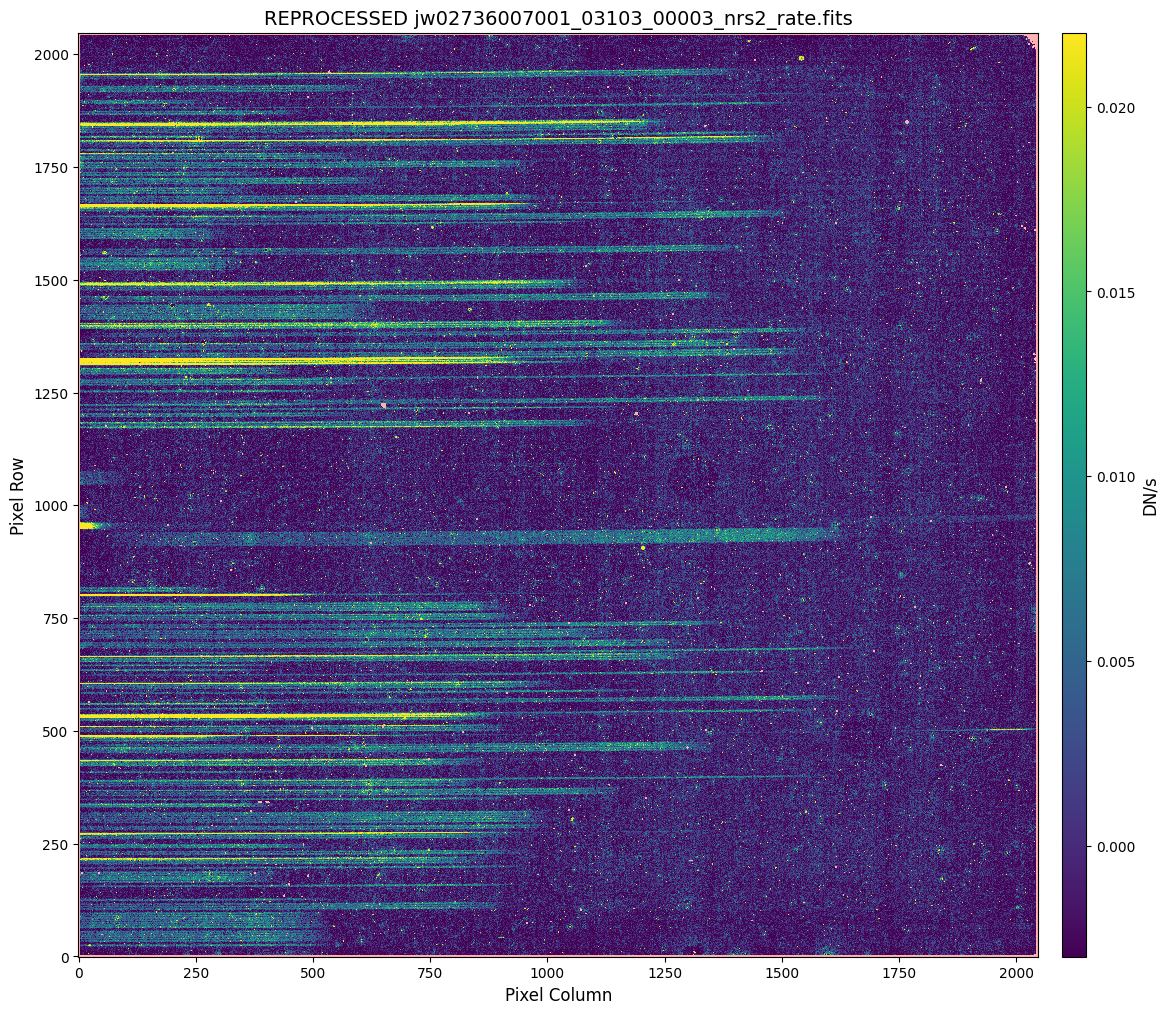

In [45]:
if doviz:
    rate_file = rate_sci[-1]  # Show the last rate file, as an example.
    display_rate(rate_file, vmin=-0.003, vmax=0.022, scale='linear',
                title_prefix='REPROCESSED')  # , extname='dq')

---

### 8.2 Display `Spec2Pipeline` Products

Use Jdaviz [Mosviz](https://jdaviz.readthedocs.io/en/stable/mosviz/index.html) to visualize and analyze the Stage 2 2D and 1D calibrated spectra. For more information on these visualization tools and plotting capabilities, refer to the official documentation linked.

In [46]:
# Plot the Stage 3 MOS spectra with Mosviz.
if doviz:
    mosviz = Mosviz()
    spectra_1d = glob.glob(spec2_dir+'*x1d.fits')
    spectra_2d = glob.glob(spec2_dir+'*s2d.fits')
    image = None  # If you have 'mymosaic.fits'
    mosviz.load_data(spectra_1d=spectra_1d, spectra_2d=spectra_2d, images=image)
    mosviz.show()

<IPython.core.display.Javascript object>

Application(config='mosviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.1/mosviz/index.html', events=['c…

Draw boxes around the extraction regions for each source in a `_rate.fits` file using the slit information from the corresponding Stage 2 calibrated products (`_cal.fits` or `_s2d.fits`). These boxes should be large enough to accommodate the curved spectral traces. While neighboring boxes may overlap, the spectra themselves do not.

2025-04-18 01:25:29,341 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(

2025-04-18 01:25:29,674 - stpipe - WARNING - /tmp/ipykernel_52441/1446724282.py:143: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



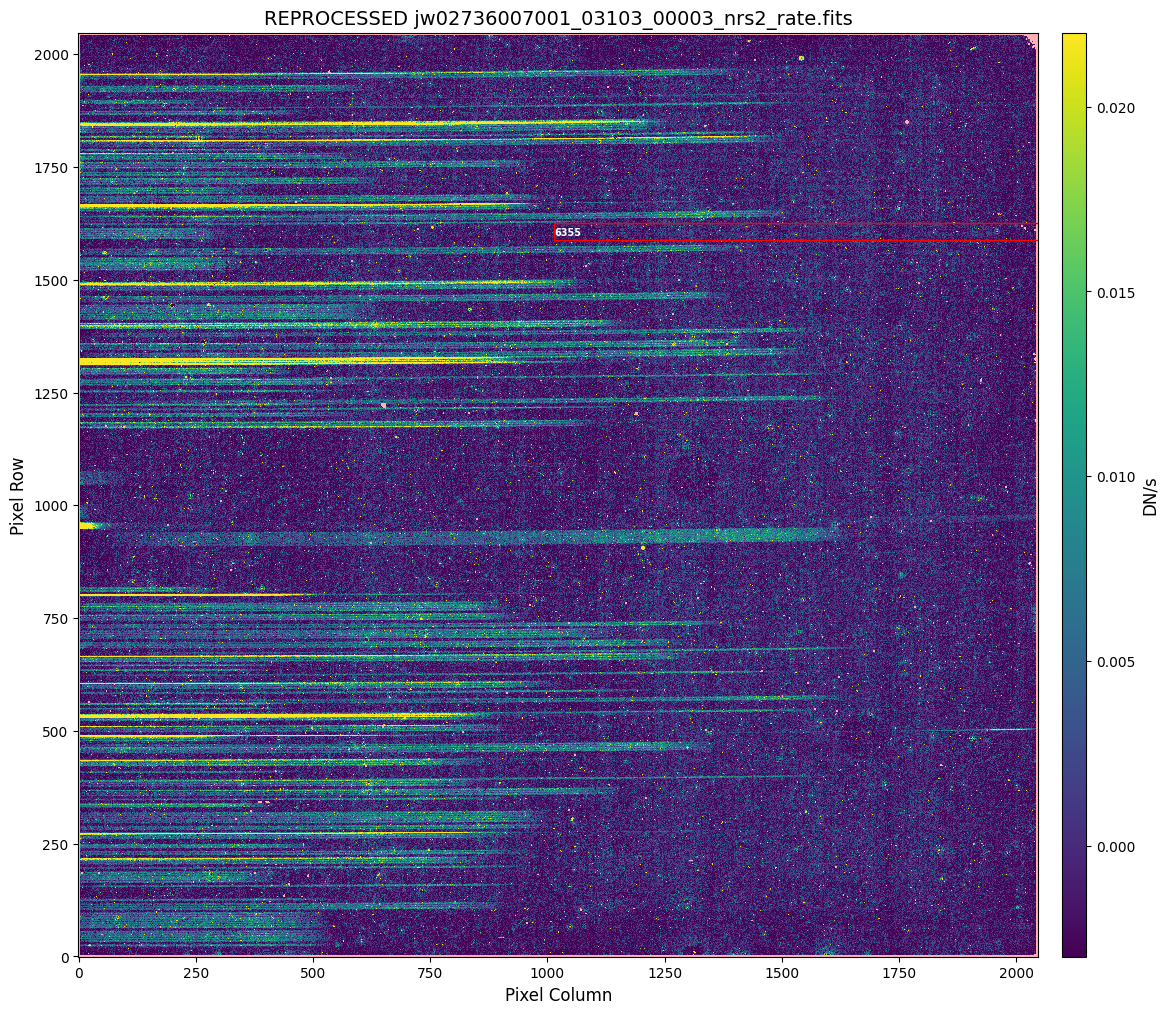

In [47]:
if doviz:
    rate_file = rate_sci[-1]  # Show the last rate file, as an example.
    display_rate(rate_file, slits_models=sci_cal[0], vmin=-0.003, vmax=0.022, scale='linear',
                title_prefix='REPROCESSED')  # , extname='dq')

<div class="alert alert-block alert-info">

Please note that the demo source data is technically defined and processed as an extended source, even though the plots above are presented in units of Jy (for point sources). For extended sources, the extraction box for the 1D spectra defaults to the center of the slitlet. In these cases, you may need to manually adjust the position of the extraction box.

Additionally, with point source data, you may sometimes observe that the extraction region is not always perfectly centered on the source. Recent improvements in resampling might exacerbate some off-centered cases, and in certain situations, the source may be completely missed. The workaround for this issue is found in [Section 9](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed)).

</div>

---
### 8.3 Display `Spec3Pipeline` Products
Inspect the Stage 3 combined calibrated spectra with Mosviz. 


In [48]:
if doviz:
    mosviz = Mosviz()
    spectra_1d = glob.glob(spec3_dir+'*x1d.fits')
    spectra_2d = glob.glob(spec3_dir+'*s2d.fits')
    image = None  # If you have 'mymosaic.fits'
    mosviz.load_data(spectra_1d=spectra_1d, spectra_2d=spectra_2d, images=image)
    mosviz.show()

Application(config='mosviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.1/mosviz/index.html', events=['c…

Note in the demo data, the default extraction region misses the positive signal for this 5-shutter slitlet target and instead extracts negative signal from one of the nod subtractions. A workaround in [Section 9](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed)) is provided.

---

## 9. Modifying the EXTRACT1D Reference File (as needed)
[extract_1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d) •
[Editing JSON reference file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data)

The `extract_1d` step's `use_source_pos` parameter in Stage 2 generally centers the 1D extraction box on the actual source location effectively and thus doesn't usually require manual adjustment. However, in some cases, adjusting the position of the extraction box by modifying the EXTRACT1D reference file may be useful. The following section demonstrates how to modify which rows in the 2D spectrum (S2D) are used for extracting the 1D spectrum (X1D).

The EXTRACT1D reference file, along with several other parameter files, can be found in the `CRDS_PATH` directory. While some files, like `.json` files, can be manually edited, we modify them using Python.

<div class="alert alert-block alert-danger">

**Warning**: Currently, there is no aperture correction in place for NIRSpec, so the `extract_width` parameter **MUST** remain unchanged (6 pixels wide) to ensure proper flux calibration! The extraction box limits (`ystart` and `ystop`) can be modified; however, if `ystart` and `ystop` do not match the `extract_width`, the `extract_width` takes precedence and is applied symmetrically around the midpoint between `ystart` and `ystop`.

</div>

In [49]:
# Modify the EXTRACT1D reference file.

# If you don't know the reference file name this should work.
# extract_1d_ref = Spec3Pipeline().get_reference_file(stage3_s2d, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0009.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0009.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    # All of these values are zero-indexed integers.
    # The start and stop limits are inclusive.

    # ANY MOS SLITLET
    params["apertures"][0]["extract_width"] = 6
    params["apertures"][0]["ystart"] = 22
    params["apertures"][0]["ystop"] = 27

# Write changes to a new file.
newData = json.dumps(params, indent=4)
# Add the suffix '_fs' to distinguish the file from the default version.
basename = os.path.basename(extract_1d_ref)[:-5]
extract_1d_ref_mod = os.path.join(spec3_dir, basename + "_mos.json")
with open(extract_1d_ref_mod, "w") as file:
    file.write(newData)

In [50]:
# Inspect the EXTRACT1D reference file.
with open(extract_1d_ref_mod, 'r') as f_obj:
    extract_1d_ref_mod_data = json.load(f_obj)

JSON(extract_1d_ref_mod_data, expanded=True)

<IPython.core.display.JSON object>

Rerun Extract1d step using the new EXTRACT1D reference file.

In [51]:
for s2d in stage3_s2d:
    Extract1dStep.call(s2d,
                       save_results=True,
                       output_dir=spec3_dir,
                       output_use_model=True,
                       suffix='x1d_mod',  # Default suffix is `_extract1dstep.fits`
                       use_source_posn=False,
                       override_extract1d=extract_1d_ref_mod)

2025-04-18 01:25:33,128 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2025-04-18 01:25:33,315 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/f290lp_g395m_s000006355_s2d.fits',).
2025-04-18 01:25:33,318 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_mod
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: False
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log

In [52]:
mosviz = Mosviz()
spectra_1d = glob.glob(spec3_dir+'*x1d_mod.fits')
spectra_2d = glob.glob(spec3_dir+'*s2d.fits')
image = None  # If you have 'mymosaic.fits'
mosviz.load_data(spectra_1d=spectra_1d, spectra_2d=spectra_2d, images=image)
mosviz.show()

Application(config='mosviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.1/mosviz/index.html', events=['c…

To overlay the spectra for comparison run the cell below.

2025-04-18 01:25:36,131 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(

2025-04-18 01:25:36,233 - stpipe - WARNING - /tmp/ipykernel_52441/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



147
Expanding wavelength gap 4.70 -- 4.96 μm
147
Expanding wavelength gap 4.70 -- 4.96 μm


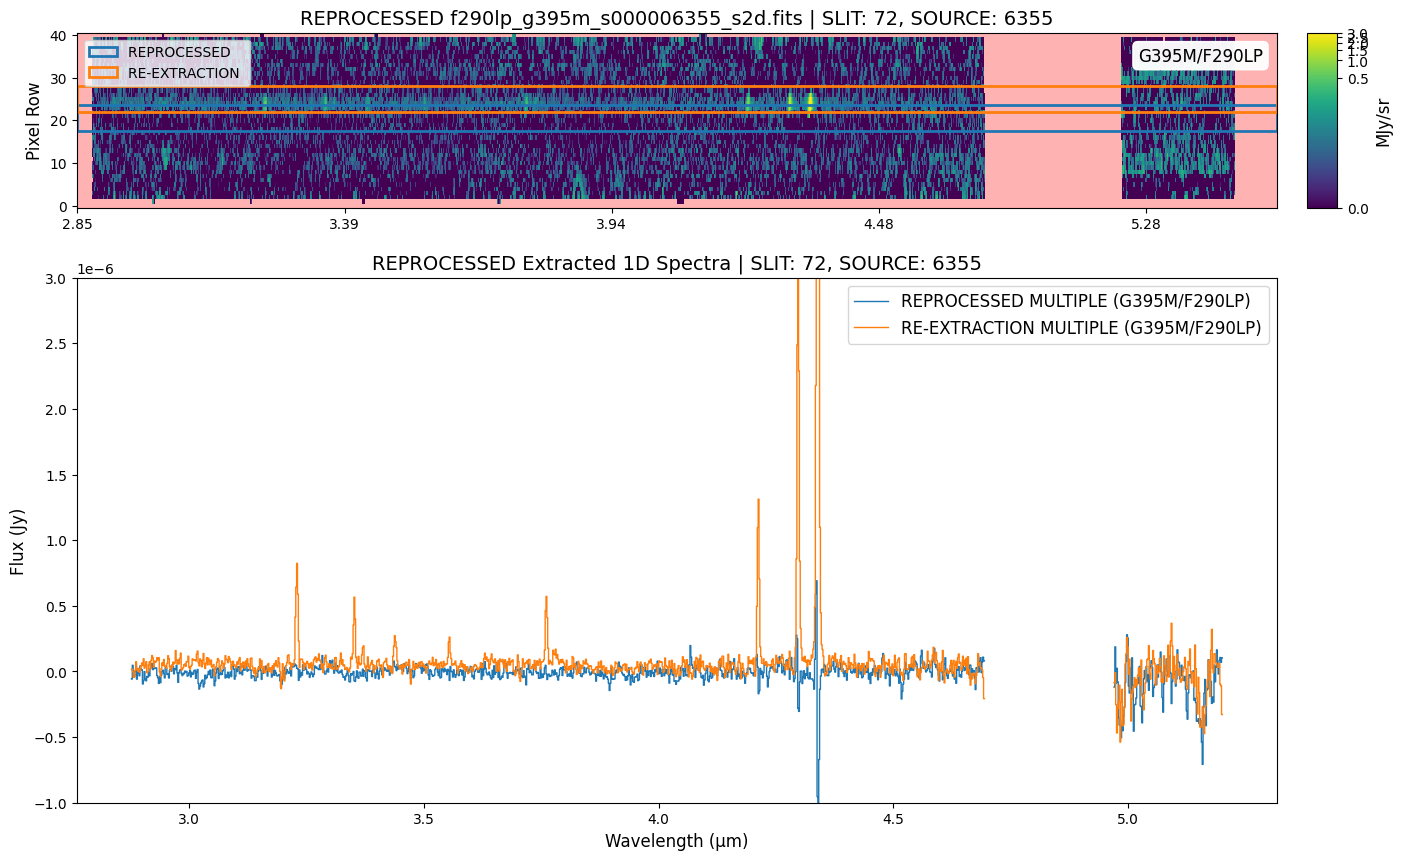

In [53]:
if doviz:
    stage3_x1ds_mod = sorted(glob.glob(spec3_dir + '*_x1d_mod.fits'))
    display_spectra(stage3_s2d + stage3_x1d, compare_x1d=stage3_x1ds_mod,
                    source_id=source_ids[0] or None, source_type='POINT', scale='log',
                    vmin=0, vmax=3, y_limits=(-1e-6, 0.3e-5),
                    title_prefix='REPROCESSED', is_stage3=True)

---
## Related Notebooks
* [NIRSpec Workaround Notebooks](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General)
* [JDAT: JWST Data Analysis Example Notebooks](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks)
* Notebooks running pipeline on simulated NIRSpec MOS data:
[JWebbinar7 (Oct 2021)](https://github.com/spacetelescope/jwebbinar_prep/blob/webbinar7/mos_session/jwebbinar7_nirspecmos.ipynb) •
[JDAT (2021)](https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/mos-spectroscopy/MOSspec_sv06_revised.ipynb) •
[JADES (June 2022)](https://github.com/eclake/NIRSpec_GTO_sims_STScI_reduction/blob/master/NIRSpec%20GTO%20IPS%20Simultions.ipynb)
* [Notebook processing ERO SMACS0723 NIRSpec MOS data](https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-smacs0723.ipynb)
using the JWST pipeline and
[msaexp](https://github.com/gbrammer/msaexp)
* [MOSViz notebook analyzing NIRSpec MOS spectra](https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html)
* [Optimal extraction](https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral_Extraction-static.html)

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>

[Top of Page](#NIRSpec-MOS-Pipeline-Notebook)